# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Đỗ Hoàng Duy Hưng
- MSSV: 23127049
- Lớp: 23CLC01

## Import các thư viện liên quan

In [165]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr
import os
from tqdm import tqdm
import pandas as pd 
import seaborn as sns


## Helper functions

In [166]:
#Image Processing and Image I/O Function

def read_img(img_path):
    img = Image.open(img_path)
    img.convert('RGB')
    return np.array(img)

def show_img(img_2d):
    plt.imshow(img_2d)
    plt.title('Image')
    plt.axis('off')
    plt.show()


def save_img(img_2d, img_path):
    img = Image.fromarray(img_2d)
    img.save('output.png')


def convert_img_to_1d(img_2d):
    image = img_2d.reshape(-1 , 3)
    return image


def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    n_pixels, n_channels = img_1d.shape
    labels = np.zeros(n_pixels, dtype=np.int32)

    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, size=(k_clusters, n_channels)).astype(np.float32)
    elif init_centroids == 'in_pixels':
        indices = np.random.choice(n_pixels, k_clusters, replace=False)
        centroids = img_1d[indices].astype(np.float32)
    else:
        raise ValueError("init_centroids must be 'random' or 'in_pixels'")

    for iteration in range(max_iter):
        distances = np.linalg.norm(img_1d[:, np.newaxis] - centroids, axis=2)
        new_labels = np.argmin(distances, axis=1)

        if np.array_equal(labels, new_labels):
            print(f"K-Means converged at iteration {iteration}")
            break
        labels = new_labels

        for k in range(k_clusters):
            cluster_points = img_1d[labels == k]
            if len(cluster_points) > 0:
                centroids[k] = np.mean(cluster_points, axis=0)

    return centroids.astype(np.uint8), labels


def generate_2d_img(img_2d_shape, centroids, labels):
    height, width, _ = img_2d_shape

    img_flat = centroids[labels]

    img_2d = img_flat.reshape((height, width, 3))

    return img_2d

#Evaluate Metrics Function

def MSE(img_2d , compressed_img):
    assert img_2d.shape == compressed_img.shape
    
    diff = img_2d.astype(np.float32) - compressed_img.astype(np.float32)
    mse = np.mean(np.square(diff))
    
    return mse


def Compress_Ratio(img_2d , compressed_img):
    size_real = os.path.getsize(img_2d)
    size_compress = os.path.getsize(compressed_img)
    return size_compress / size_real



## Config

In [167]:
k_clusters = 4
max_iter = 10

## Your tests

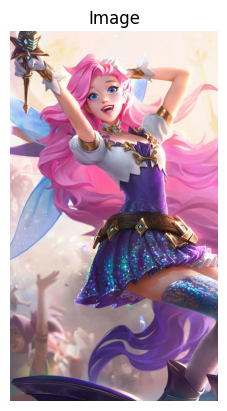

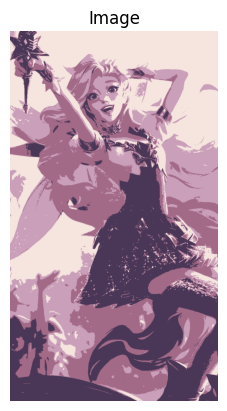

In [168]:
img = read_img('C:/Users/Admin/Documents/Work/Applied Math and Stat/Project1/9.jpg')
show_img(img)
img_1d = img.reshape(-1, 3)
centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids='random')
compressed_img = generate_2d_img(img.shape, centroids, labels)
save_img(compressed_img,'C:/Users/Admin/Documents/Work/Applied Math and Stat/Project1/9.jpg')
img2 = convert_img_to_1d(img)
img2
show_img(compressed_img)

In [169]:
MSE(img,compressed_img=compressed_img)
Compress_Ratio('C:/Users/Admin/Documents/Work/Applied Math and Stat/Project1/9.jpg', 'C:/Users/Admin/Documents/Work/Applied Math and Stat/Project1/output.png')

0.6230750656249756

## Evaluate Metrics

In [170]:

List_Image = ['1.png' , '2.jpg' , '3.png' , '4.jpg' , '5.jpg' , '6.jpg' , '7.jpg' , '8.jpg' , '9.jpg' , '10.jpg']

K_list = [4, 8, 16]

results = []

for img_path in tqdm(List_Image):
    img = read_img(img_path)
    img_1d = convert_img_to_1d(img)
    shape = img.shape

    for k in K_list:
        centroids, labels = kmeans(img_1d, k, max_iter=10)
        compressed = generate_2d_img(shape, centroids, labels)

        temp_out = f'temp_k{k}_{os.path.basename(img_path)}'
        Image.fromarray(compressed).save(temp_out)

        mse = MSE(img, compressed)
        ratio = Compress_Ratio(img_path, temp_out)

        results.append({
            'Image': os.path.basename(img_path),
            'K': k,
            'MSE': mse,
            'Ratio': ratio
        })

        os.remove(temp_out)

 50%|█████     | 5/10 [00:51<00:48,  9.69s/it]

K-Means converged at iteration 8


100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


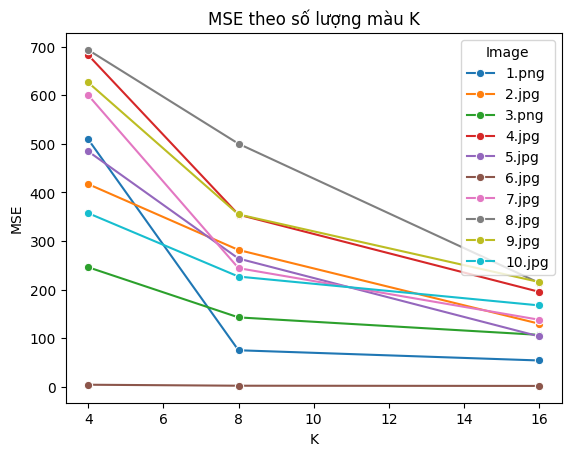

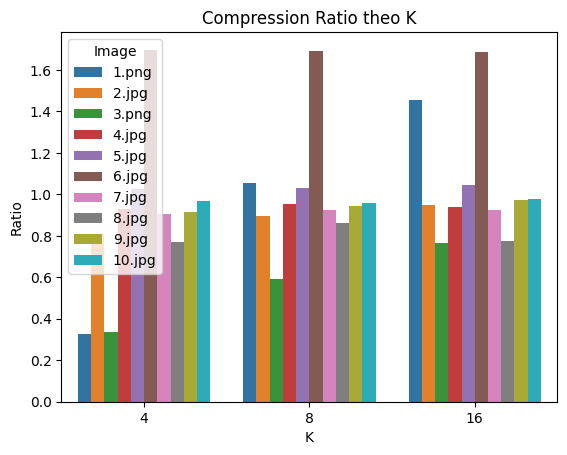

In [174]:
df = pd.DataFrame(results)

# Line plot MSE theo K cho từng ảnh
sns.lineplot(data=df, x='K', y='MSE', hue='Image', marker='o')
plt.title('MSE theo số lượng màu K')
plt.show()

# Bar plot Compression Ratio theo K
sns.barplot(data=df, x='K', y='Ratio', hue='Image')
plt.title('Compression Ratio theo K')
plt.show()

## Main FUNCTION

In [ ]:
def main():
    path = input("Nhập tên file ảnh (ví dụ: 1.png): ")
    k = int(input("Nhập số lượng màu (K): "))
    format_choice = input("Bạn muốn lưu ảnh dưới định dạng nào? (png/pdf): ").strip().lower()

    full_path = 'C:/Users/Admin/Documents/Work/Applied Math and Stat/Project1/' + path

    img = read_img(full_path)
    img_1d = convert_img_to_1d(img)

    centroids, labels = kmeans(img_1d, k, max_iter=100, init_centroids='random')
    new_img = generate_2d_img(img.shape, centroids, labels)

    show_img(new_img)

    if format_choice == 'png':
        save_img(new_img, "output.png")
        print("Ảnh nén đã được lưu thành output.png")
    elif format_choice == 'pdf':
        plt.imsave("output.pdf", new_img.astype(np.uint8))
        print("Ảnh nén đã được lưu thành output.pdf")
    else:
        print("Lựa chọn không hợp lệ. Chỉ hỗ trợ 'png' hoặc 'pdf'.")

K-Means converged at iteration 12


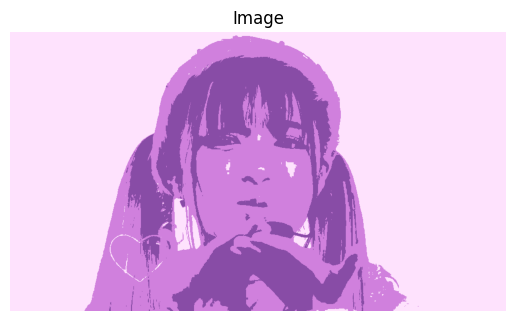

Ảnh nén đã được lưu thành output.png


In [ ]:
if __name__ == "__main__":
    main()